In [1]:
import pygame,random,gymnasium as gym,numpy as np,matplotlib.pyplot as plt
#import tensorflow as tf,os,warnings
#from tensorflow.keras import optimizers, losses
#from tensorflow.keras import Model
from collections import deque
#from tensorflow.python.framework import random_seed
from IPython.display import clear_output
#warnings.filterwarnings("ignore", message="Model's `__init__()` arguments contain non-serializable objects.")
import torch ,os
seed = 1
s =int(seed)
np.random.seed(s)
np.random.default_rng(s)
os.environ['PYTHONHASHSEED'] = str(s)
random.seed(seed)

torch.manual_seed(s)
torch.cuda.manual_seed_all(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

pygame 2.1.3 (SDL 2.0.22, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Network(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        """
        PyTorch version of your network.
        :param state_size: input dimension (not used explicitly in linear layers here,
                           but kept for API compatibility)
        :param action_size: number of actions (output dimension)
        :param cfg: object with attribute hidden_size
        """

        super().__init__()
        hidden1 = 128
        hidden2 = 64
        hidden3 = 32
        self.num_action = action_size
        self.layer1 = nn.Linear(state_size, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, hidden3)
        self.value_head = nn.Linear(hidden3,1)
        self.advantage_head = nn.Linear(hidden3,self.num_action)
        self.activation = nn.ReLU()

    def forward(self, state):
        """
        Forward pass.
        x: tensor of shape (batch, state_size) or (state_size,) for single sample
        returns: Q-values tensor of shape (batch, num_action)
        """
        if state.dim() == 1:
            state = state.unsqueeze(0)
        
        h = self.activation(self.layer1(state))
        h = self.activation(self.layer2(h))
        h = self.activation(self.layer3(h))

        value = self.value_head(h)                  
        advantages = self.advantage_head(h)      
        
        mean_advantages = advantages.mean(dim=1, keepdim=True)  
        centered_advantages = advantages - mean_advantages  

        q_values = value + centered_advantages 

        return q_values



episode: 1/1000, score: -119.80089748398322, e: 1.0
episode: 2/1000, score: -119.7490651056366, e: 0.9882
episode: 3/1000, score: -55.87689107043781, e: 0.9765
episode: 4/1000, score: -131.25393477154051, e: 0.965
episode: 5/1000, score: -148.7062801176745, e: 0.9536
episode: 6/1000, score: -101.87127420971846, e: 0.9423
episode: 7/1000, score: -48.4727094547603, e: 0.9312
episode: 8/1000, score: -304.91337242996616, e: 0.9202
episode: 9/1000, score: -177.90668610259507, e: 0.9094
episode: 10/1000, score: -99.55835920961898, e: 0.8987
episode: 11/1000, score: 5.576581207757229, e: 0.8881
episode: 12/1000, score: -241.9346520693352, e: 0.8776
episode: 13/1000, score: -35.15415550975051, e: 0.8672
episode: 14/1000, score: -231.50533784702145, e: 0.857
episode: 15/1000, score: -235.20512213626372, e: 0.8469
episode: 16/1000, score: -154.87853433748268, e: 0.8369
episode: 17/1000, score: -410.1489627065259, e: 0.8271
episode: 18/1000, score: -185.6496782205021, e: 0.8173
episode: 19/1000, 

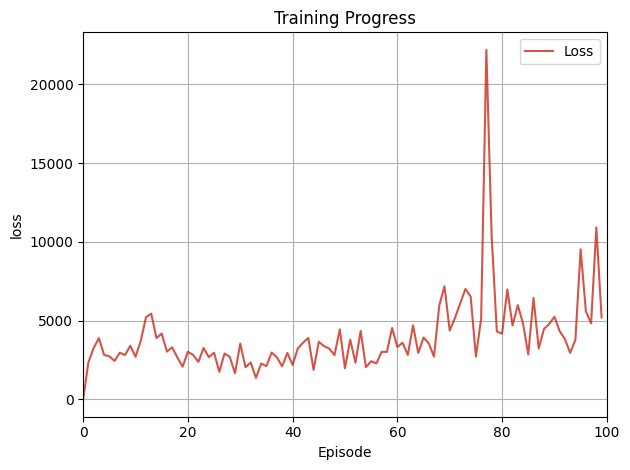

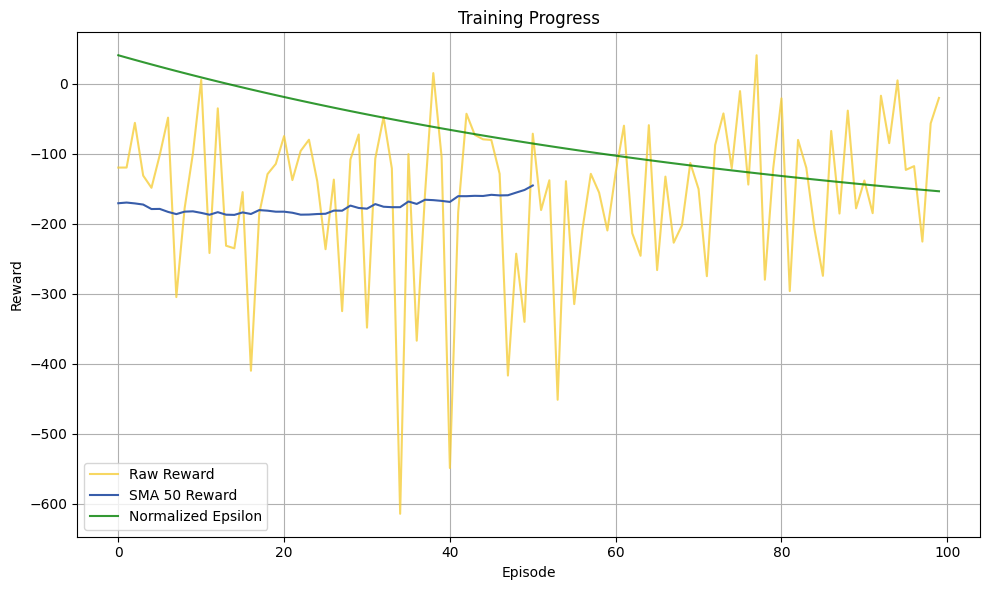

episode: 101/1000, score: -19.05658431447803, e: 0.3082
episode: 102/1000, score: -19.317316473884645, e: 0.3046
episode: 103/1000, score: -56.905646022460076, e: 0.3011
episode: 104/1000, score: -21.097254216034955, e: 0.2976
episode: 105/1000, score: -299.3669362080848, e: 0.2942
episode: 106/1000, score: 4.622054275119879, e: 0.2908
episode: 107/1000, score: 25.347336926589335, e: 0.2875
episode: 108/1000, score: -239.76711561906367, e: 0.2842
episode: 109/1000, score: 11.918685867881734, e: 0.2809
episode: 110/1000, score: 39.55785752811465, e: 0.2777
episode: 111/1000, score: -186.1672226451591, e: 0.2745
episode: 112/1000, score: 35.618250896114404, e: 0.2713
episode: 113/1000, score: -207.2376224997705, e: 0.2682
episode: 114/1000, score: -75.22760013447257, e: 0.2651
episode: 115/1000, score: -82.20509845335718, e: 0.2621
episode: 116/1000, score: -49.211778603744065, e: 0.2591
episode: 117/1000, score: 94.26447073288568, e: 0.2561
episode: 118/1000, score: -78.20661856065489, 

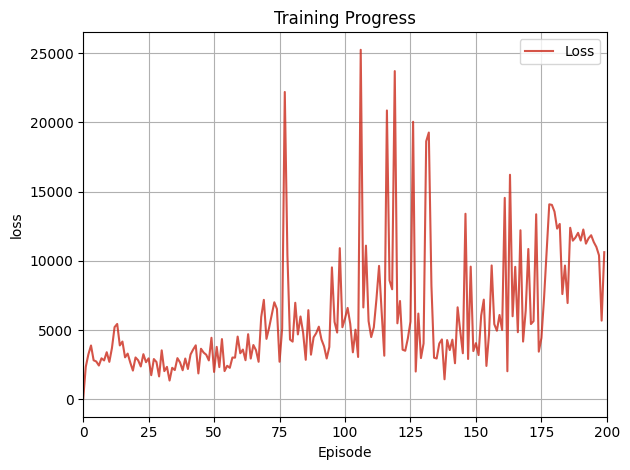

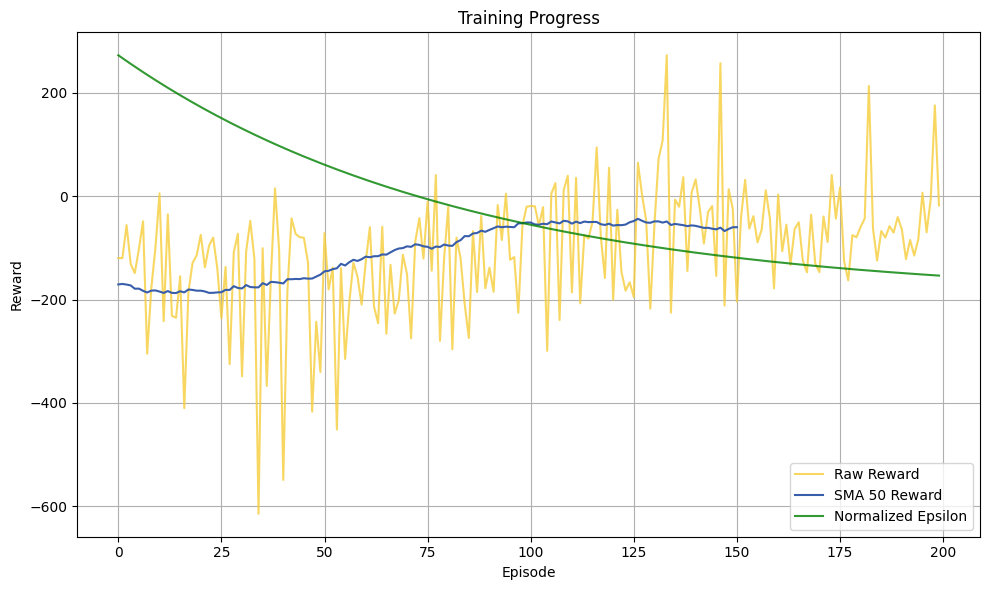

episode: 201/1000, score: -83.94548149447174, e: 0.09981
episode: 202/1000, score: -164.98420398802455, e: 0.09874
episode: 203/1000, score: -9.10653849541617, e: 0.09768
episode: 204/1000, score: -60.790936289587215, e: 0.09664
episode: 205/1000, score: 75.49357030068921, e: 0.0956
episode: 206/1000, score: -90.74799933685611, e: 0.09458
episode: 207/1000, score: -16.437422931300762, e: 0.09357
episode: 208/1000, score: -14.34186794987938, e: 0.09257
episode: 209/1000, score: -106.20361957520105, e: 0.09159
episode: 210/1000, score: -195.84526997548244, e: 0.09062
episode: 211/1000, score: -233.70192183951175, e: 0.08966
episode: 212/1000, score: -75.09765238536396, e: 0.0887
episode: 213/1000, score: -30.126386871407103, e: 0.08777
episode: 214/1000, score: -58.36357221594177, e: 0.08684
episode: 215/1000, score: -114.3563800981494, e: 0.08592
episode: 216/1000, score: -84.475947128217, e: 0.08502
episode: 217/1000, score: -73.63190930614218, e: 0.08412
episode: 218/1000, score: -128

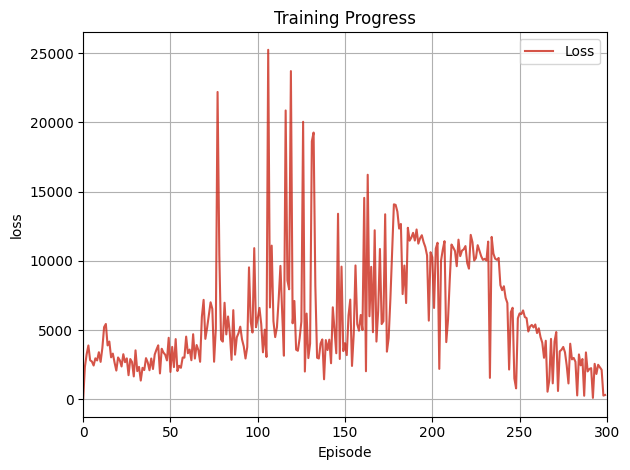

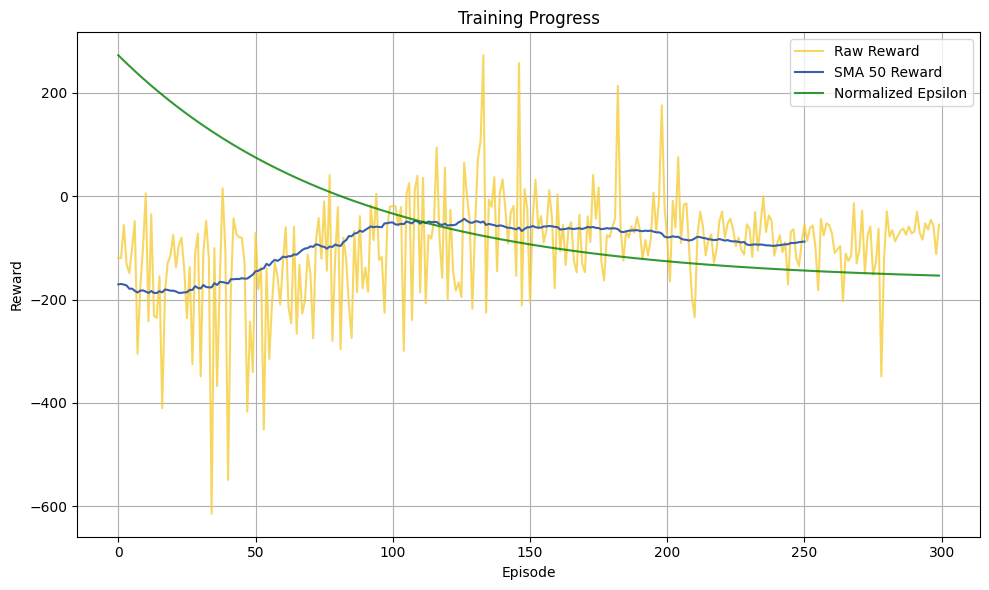

episode: 301/1000, score: -23.13788182643236, e: 0.03705
episode: 302/1000, score: -152.1846936157215, e: 0.03673
episode: 303/1000, score: -88.31638920483798, e: 0.03641
episode: 304/1000, score: -24.173017225065127, e: 0.03609
episode: 305/1000, score: -39.12887155575944, e: 0.03578
episode: 306/1000, score: -78.6556048032644, e: 0.03548
episode: 307/1000, score: -126.00242541417173, e: 0.03517
episode: 308/1000, score: -118.91854818042871, e: 0.03487
episode: 309/1000, score: -109.84721800557557, e: 0.03457
episode: 310/1000, score: -28.667608507209298, e: 0.03428
episode: 311/1000, score: -222.6551702917476, e: 0.03399
episode: 312/1000, score: -49.11387459976155, e: 0.03371
episode: 313/1000, score: -76.35109268067805, e: 0.03342
episode: 314/1000, score: -228.39677423882472, e: 0.03314
episode: 315/1000, score: 26.354827697280086, e: 0.03287
episode: 316/1000, score: -31.751650141775137, e: 0.03259
episode: 317/1000, score: -35.26491058944278, e: 0.03232
episode: 318/1000, score:

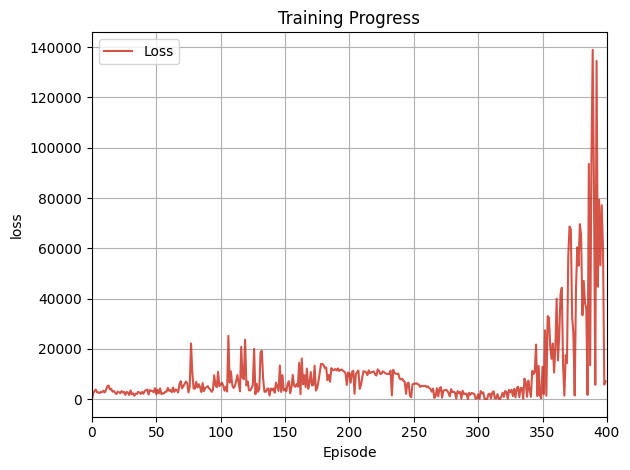

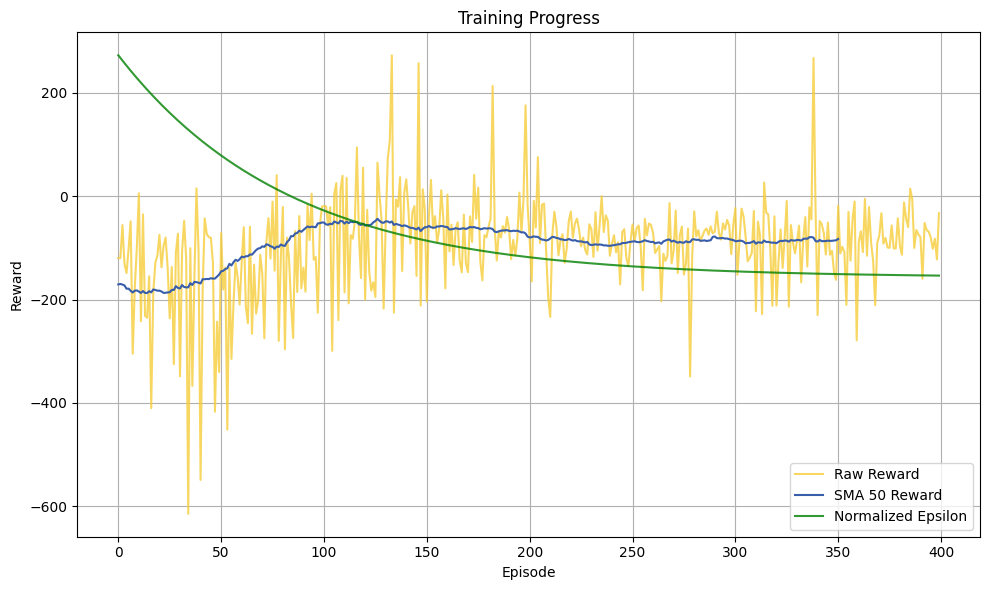

episode: 401/1000, score: -117.72264469629464, e: 0.01815
episode: 402/1000, score: -60.48625278590178, e: 0.01805
episode: 403/1000, score: -72.32801803653834, e: 0.01795
episode: 404/1000, score: -76.9507833027697, e: 0.01786
episode: 405/1000, score: -109.70632119798923, e: 0.01777
episode: 406/1000, score: -88.18041003596089, e: 0.01767
episode: 407/1000, score: -72.05686067589525, e: 0.01758
episode: 408/1000, score: -97.05782002241718, e: 0.01749
episode: 409/1000, score: -98.77088434526947, e: 0.0174
episode: 410/1000, score: -33.608775526187884, e: 0.01731
episode: 411/1000, score: -70.97518438414949, e: 0.01723
episode: 412/1000, score: -36.61120198758776, e: 0.01714
episode: 413/1000, score: -147.1859844372881, e: 0.01705
episode: 414/1000, score: -81.58596131973248, e: 0.01697
episode: 415/1000, score: -73.18341621595836, e: 0.01689
episode: 416/1000, score: -46.873491991443615, e: 0.01681
episode: 417/1000, score: -68.24021417082058, e: 0.01672
episode: 418/1000, score: -11

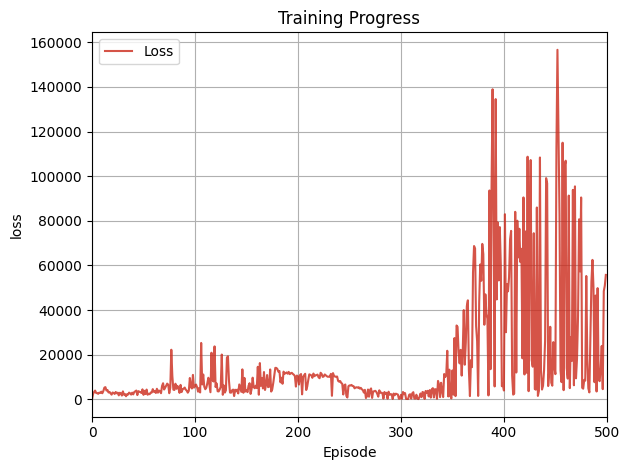

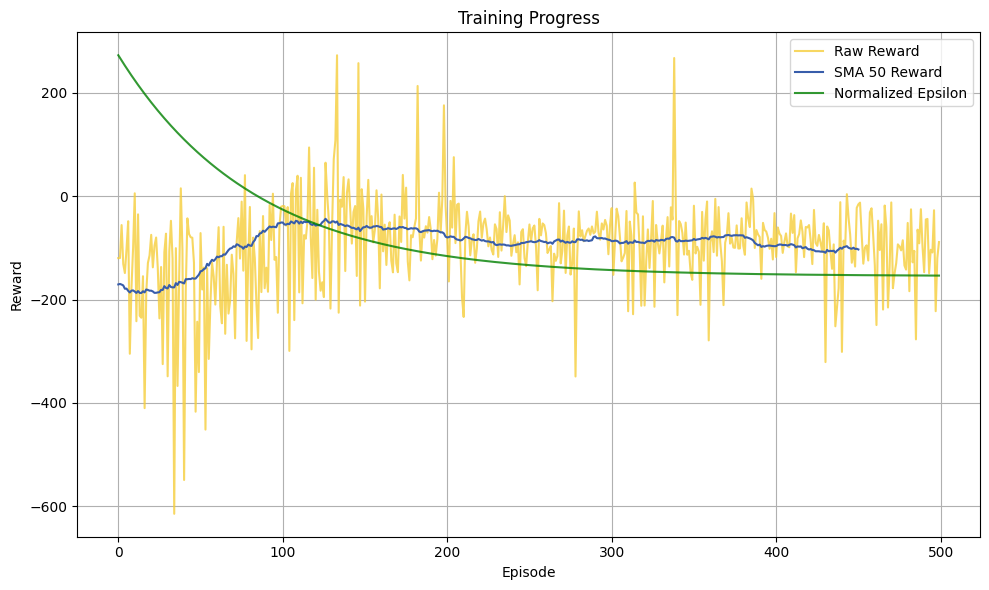

episode: 501/1000, score: -64.56917654245588, e: 0.01245
episode: 502/1000, score: -124.88477721250027, e: 0.01242
episode: 503/1000, score: -97.08091744917728, e: 0.0124
episode: 504/1000, score: -339.26436094815745, e: 0.01237
episode: 505/1000, score: -40.22781110214123, e: 0.01234
episode: 506/1000, score: -18.388863310967064, e: 0.01231
episode: 507/1000, score: -68.30966754838931, e: 0.01228
episode: 508/1000, score: -258.4495695494491, e: 0.01226
episode: 509/1000, score: -69.15181440399066, e: 0.01223
episode: 510/1000, score: -155.62954409943686, e: 0.0122
episode: 511/1000, score: -141.83939926235308, e: 0.01218
episode: 512/1000, score: -80.27978179311579, e: 0.01215
episode: 513/1000, score: -26.341346194256943, e: 0.01212
episode: 514/1000, score: -24.080706833289668, e: 0.0121
episode: 515/1000, score: -172.90836955837233, e: 0.01207
episode: 516/1000, score: -63.726130977248594, e: 0.01205
episode: 517/1000, score: -100.22064602198077, e: 0.01203
episode: 518/1000, score

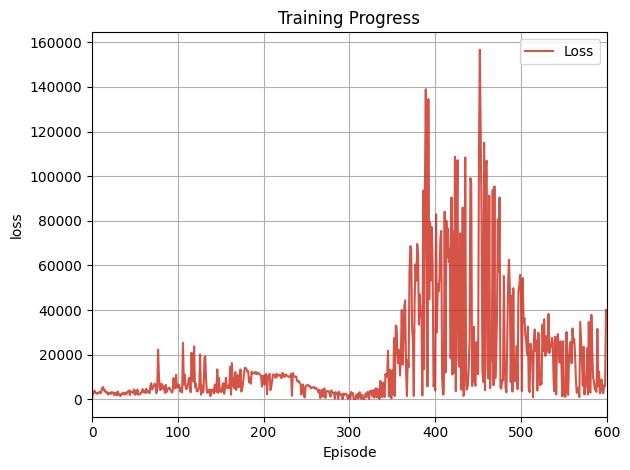

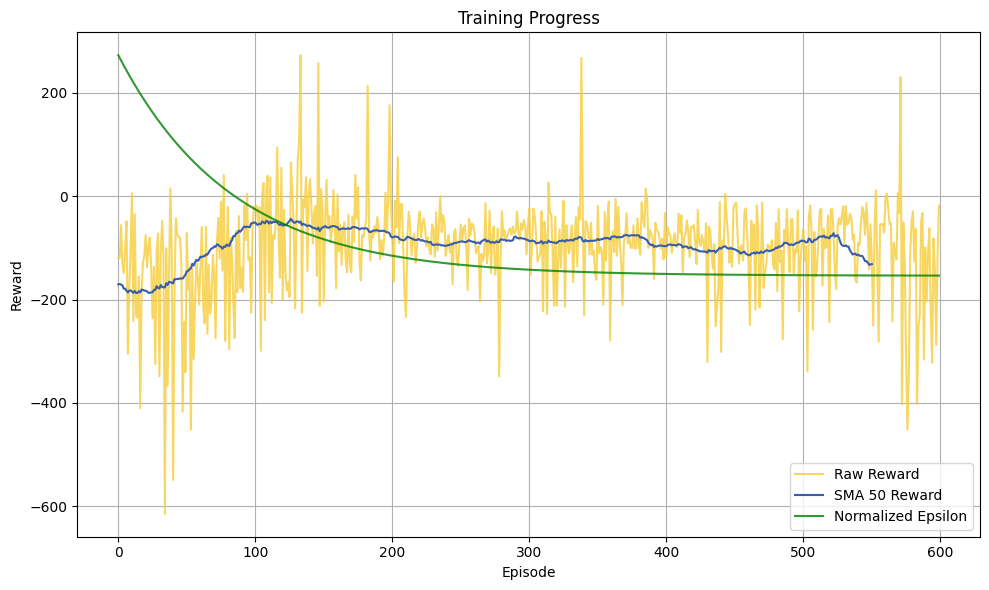

episode: 601/1000, score: -142.21503157955044, e: 0.01074
episode: 602/1000, score: -81.52472241592206, e: 0.01073
episode: 603/1000, score: -86.74543592308052, e: 0.01072
episode: 604/1000, score: -70.86461138394777, e: 0.01071
episode: 605/1000, score: -274.0460972815494, e: 0.0107
episode: 606/1000, score: -38.37496614199124, e: 0.0107
episode: 607/1000, score: 9.715299284519643, e: 0.01069
episode: 608/1000, score: -106.09199607961108, e: 0.01068
episode: 609/1000, score: -155.7769140504045, e: 0.01067
episode: 610/1000, score: -52.0567859235711, e: 0.01066
episode: 611/1000, score: -159.10478324505078, e: 0.01066
episode: 612/1000, score: -316.11283814052535, e: 0.01065
episode: 613/1000, score: -57.51370624456052, e: 0.01064
episode: 614/1000, score: -21.416664480600428, e: 0.01063
episode: 615/1000, score: -92.82783020272957, e: 0.01062
episode: 616/1000, score: 20.36949093512567, e: 0.01062
episode: 617/1000, score: -314.9570478580876, e: 0.01061
episode: 618/1000, score: -226.

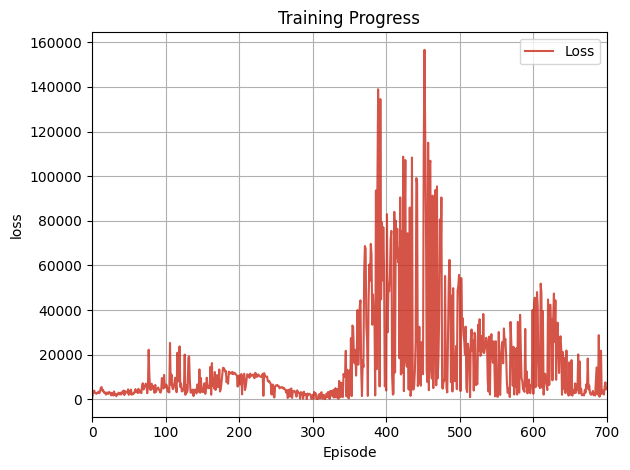

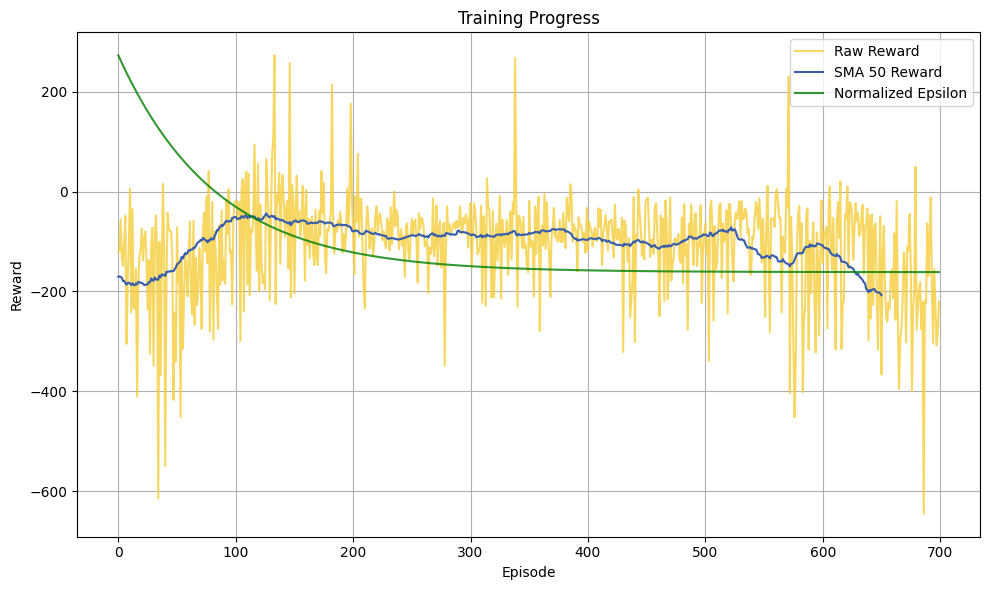

episode: 701/1000, score: -140.73765010963635, e: 0.01022
episode: 702/1000, score: -512.8830403966851, e: 0.01022
episode: 703/1000, score: -92.41472463660749, e: 0.01022
episode: 704/1000, score: -188.83150497692003, e: 0.01021
episode: 705/1000, score: -102.80495696530618, e: 0.01021
episode: 706/1000, score: -36.62255939422465, e: 0.01021
episode: 707/1000, score: -259.8884448286152, e: 0.01021
episode: 708/1000, score: -262.2608792386962, e: 0.0102
episode: 709/1000, score: -551.5625875245125, e: 0.0102
episode: 710/1000, score: -300.1030600830692, e: 0.0102
episode: 711/1000, score: -49.99134542794232, e: 0.0102
episode: 712/1000, score: -279.59720412331444, e: 0.0102
episode: 713/1000, score: -228.57874056988257, e: 0.01019
episode: 714/1000, score: -198.59002225320597, e: 0.01019
episode: 715/1000, score: -264.75403246808435, e: 0.01019
episode: 716/1000, score: -187.00650047882195, e: 0.01019
episode: 717/1000, score: -204.43282862714435, e: 0.01018
episode: 718/1000, score: -

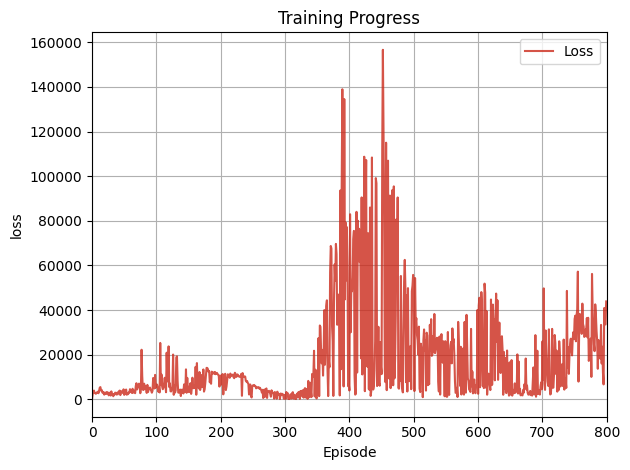

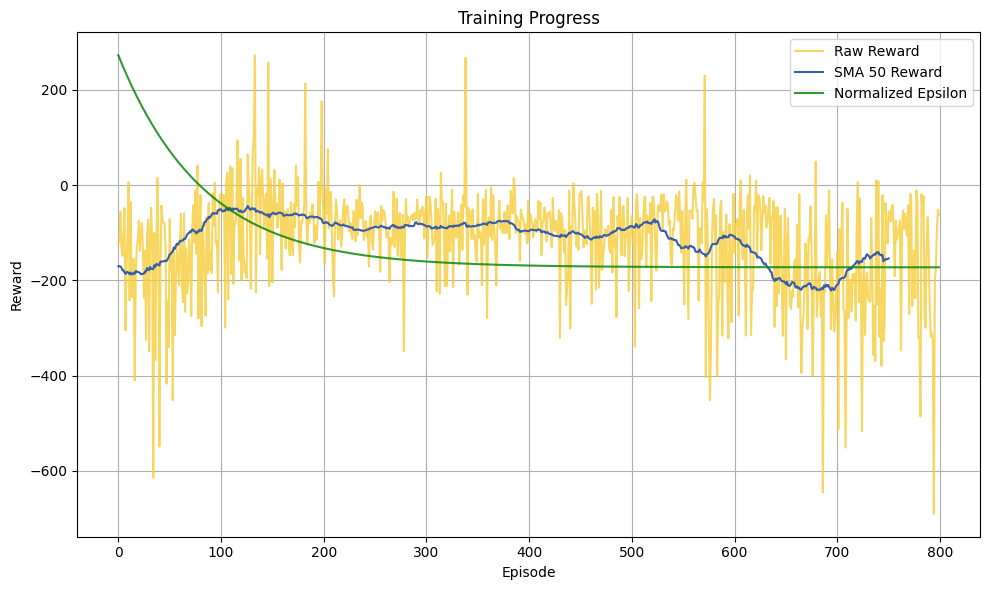

episode: 801/1000, score: -231.89542354407712, e: 0.01007
episode: 802/1000, score: -239.70523180026964, e: 0.01007
episode: 803/1000, score: -96.25144921572061, e: 0.01007
episode: 804/1000, score: -287.5310651271501, e: 0.01006
episode: 805/1000, score: -125.71502906663422, e: 0.01006
episode: 806/1000, score: -104.02100349254086, e: 0.01006
episode: 807/1000, score: -41.372209175065, e: 0.01006
episode: 808/1000, score: -411.2625272082639, e: 0.01006
episode: 809/1000, score: -82.4528213301871, e: 0.01006
episode: 810/1000, score: -40.43208806936893, e: 0.01006
episode: 811/1000, score: -76.85333733422728, e: 0.01006
episode: 812/1000, score: -111.68457020028491, e: 0.01006
episode: 813/1000, score: -309.4835695182054, e: 0.01006
episode: 814/1000, score: -291.25640458750394, e: 0.01006
episode: 815/1000, score: -113.00067644192265, e: 0.01006
episode: 816/1000, score: -234.09420822115732, e: 0.01006
episode: 817/1000, score: -337.3977667332955, e: 0.01006
episode: 818/1000, score: 

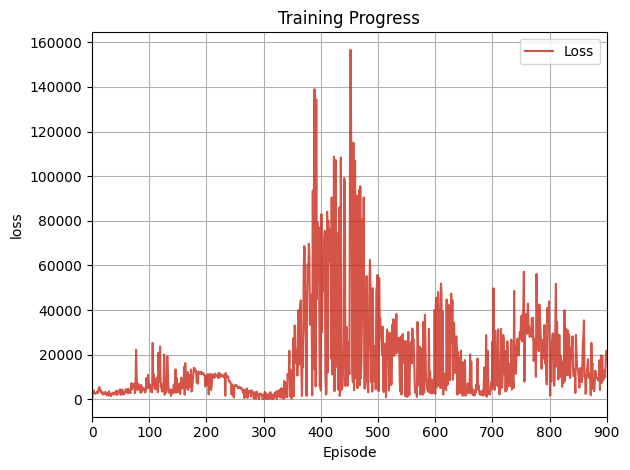

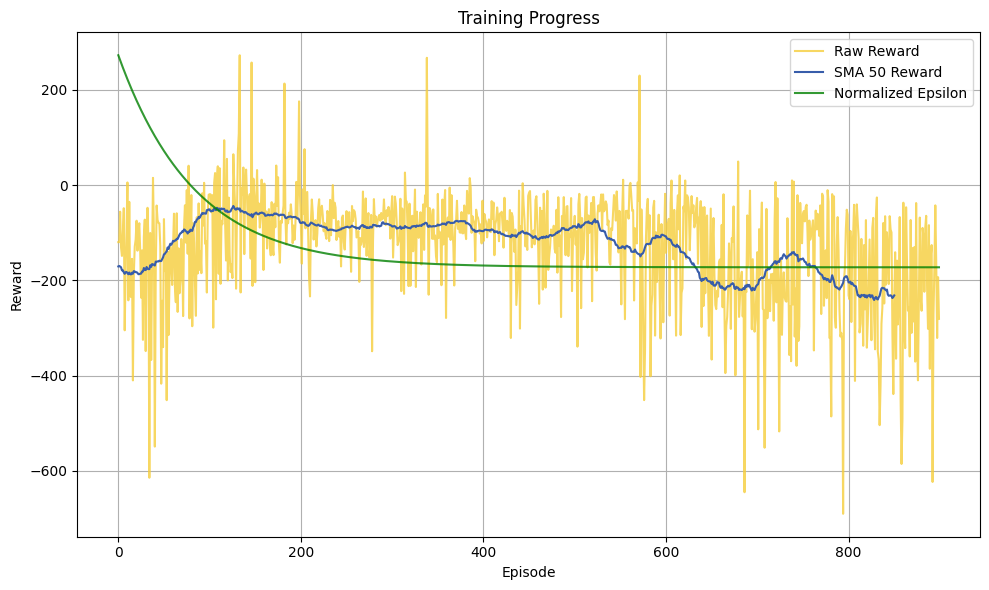

episode: 901/1000, score: -207.07654617120798, e: 0.01002
episode: 902/1000, score: -91.74003978651717, e: 0.01002
episode: 903/1000, score: -48.64121844282084, e: 0.01002
episode: 904/1000, score: -187.18515020614075, e: 0.01002
episode: 905/1000, score: -97.46167149722991, e: 0.01002
episode: 906/1000, score: -34.083967074405976, e: 0.01002
episode: 907/1000, score: -147.34394889183883, e: 0.01002
episode: 908/1000, score: 6.601148944101766, e: 0.01002
episode: 909/1000, score: -324.7424495607012, e: 0.01002
episode: 910/1000, score: -189.3953122060654, e: 0.01002
episode: 911/1000, score: -337.0629266883933, e: 0.01002
episode: 912/1000, score: -328.4291391116946, e: 0.01002
episode: 913/1000, score: -331.15445700504176, e: 0.01002
episode: 914/1000, score: -219.13379234754782, e: 0.01002
episode: 915/1000, score: -11.86216279403105, e: 0.01002
episode: 916/1000, score: -40.338174744639375, e: 0.01002
episode: 917/1000, score: -165.03219686330686, e: 0.01002
episode: 918/1000, score

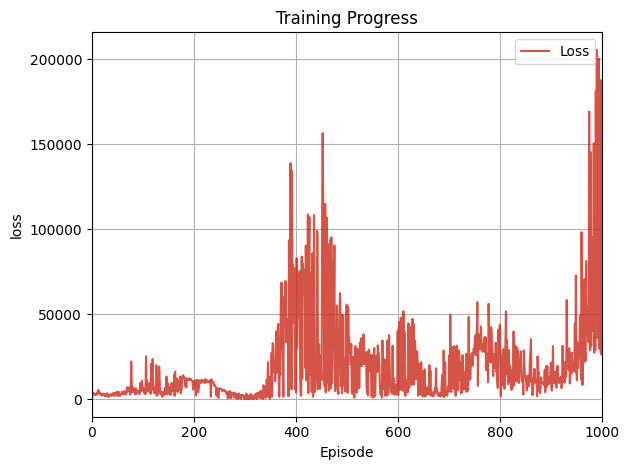

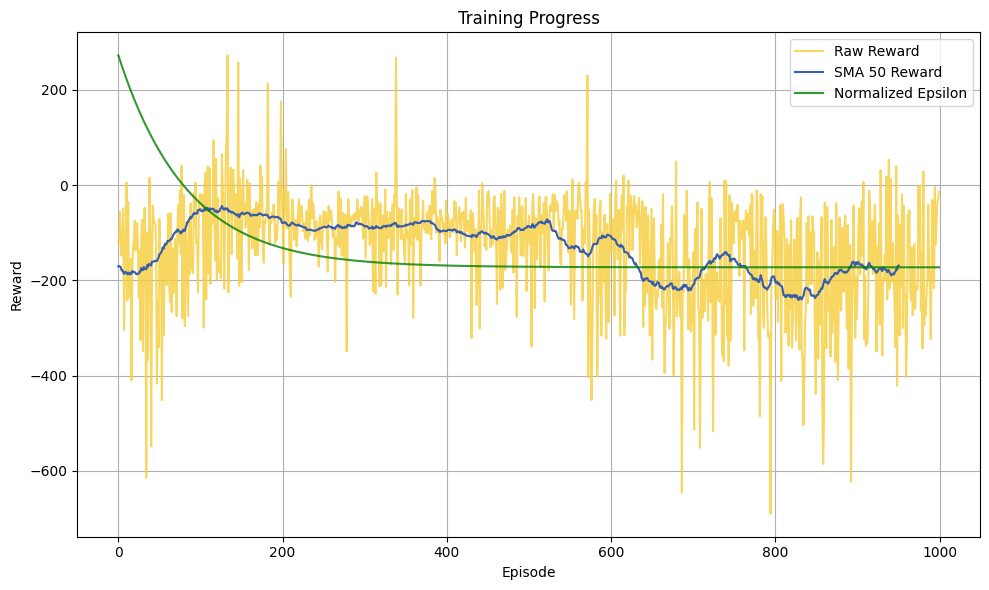

In [3]:

class DQNAgent:
    def __init__(
        self, 
        env: gym.Env,
        batch_size: int,
        target_update: int,
    ):        
        # CREATING THE Q-Network
        self.env = env
        self.action_space = env.action_space
        self.action_space.seed(seed)
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.batch_size = batch_size
        # hyper parameters
        memory_size = 100000
        self.lr = 0.001
        self.target_update = target_update
        self.gamma = 0.99
        
        self.dqn = Network(self.state_size, self.action_size)
        self.dqn_target = Network(self.state_size, self.action_size)
        self.train_start = 1000
        self.optimizer = optim.Adam(self.dqn.parameters(),lr=self.lr)        
        self.memory = deque(maxlen=memory_size)
        self.TAU = 0.005 # target network soft update hyperparameter
    
    def _process_state(self, state):
        if isinstance(state, dict):
            print("isinstance(state, dict")
            return np.concatenate([state[key].flatten() for key in sorted(state.keys())])    
        else:
            return np.asarray(state).flatten()
    # EXPLORATION VS EXPLOITATION

    def get_action(self, state, epsilon):
        state = self._process_state(state)
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
        with torch.no_grad():
            q_value = self.dqn(state)[0]
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_size)
        else:
            action = np.argmax(q_value).item() 
        return action
    
    def append_sample(self, state, action, reward, next_state, done):
        state = self._process_state(state)
        next_state = self._process_state(next_state)
        self.memory.append((state, action, reward, next_state, done))
    # UPDATING THE Q-VALUE
    def train_step(self):
        mini_batch = random.sample(self.memory, self.batch_size)

        states      = np.array([i[0] for i in mini_batch])
        actions     = np.array([i[1] for i in mini_batch])
        rewards     = np.array([i[2] for i in mini_batch])
        next_states = np.array([i[3] for i in mini_batch])
        dones       = np.array([i[4] for i in mini_batch])

        
        states      = torch.from_numpy(states).float()
        actions     = torch.from_numpy(actions).long()
        rewards     = torch.from_numpy(rewards).float()
        next_states = torch.from_numpy(next_states).float()
        dones       = torch.from_numpy(dones).float()
        
        next_Qs = self.dqn(next_states)
        next_action = torch.argmax(next_Qs, dim=1)
        next_Q_targs = self.dqn_target(next_states)
        target_value = next_Q_targs.gather(1, next_action.unsqueeze(1)).squeeze(1)

        mask = 1 - dones
        target_value = rewards + self.gamma * target_value * mask 
        
        curr_Qs = self.dqn(states)
        
        main_value = curr_Qs.gather(1, actions.unsqueeze(1)).squeeze(1)
        error = ((main_value - target_value) **2/ 2.0)
        loss = torch.mean(error)
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    # after some time interval update the target model to be same with model
    def _target_update(self):
        tau = self.TAU
        with torch.no_grad():
            for param, target_param in zip(self.dqn.parameters(), self.dqn_target.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
    def update_Gamma(self):
        self.gamma = 1 - 0.985 * (1 - self.gamma)
    def load(self, path):
        
        self.dqn = Network(self.state_size[0], self.action_size, self.cfg).to(self.device)
        self.dqn.load_state_dict(torch.load(path,map_location=self.device))
        self.dqn_target.load_state_dict(torch.load(path,map_location=self.device))
    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(self.dqn.state_dict(), path)

Train=True

env = gym.make("LunarLander-v3",render_mode="human" if not Train else None,continuous=False, gravity=-9.8,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
# parameters
target_update = 20
# INITIALIZING THE Q-PARAMETERS
hidden_size = 86
max_episodes = 1000  # Set total number of episodes to train agent on.
batch_size =128#128
# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.012            # Exponential decay rate for exploration prob
myai=False
agent = DQNAgent(
    env, 
#     memory_size, 
    batch_size, 
    target_update, 
#     epsilon_decay,
)
save_path='./weights-and-plot/final_weights'
load_path='./weights-and-plot/final_weights' + '_' + '300'
def plot_training(episode,loss_history):
        agent.save(save_path + '_' + f'{episode}')
        print('\n~~~~~~Interval Save: Model saved.\n')
        sma_reward = np.convolve(reward_history, np.ones(50)/50, mode='valid')
        max_reward=np.max(reward_history)
        min_reward=np.min(reward_history)
        #normalized_loss = np.interp(loss_history, (np.min(loss_history), np.max(loss_history)), (min_reward/2,max_reward))
        normalized_epsilon = np.interp(epsilon_history, (np.min(epsilon_history), np.max(epsilon_history)), (min_reward/4,max_reward))
        plt.plot(loss_history, label='Loss', color='#CB291A', alpha=0.8)
        
        plt.title("Training Progress")
        plt.xlabel("Episode")
        plt.ylabel("loss")

        plt.xlim(0, len(loss_history))
        
        plt.legend()
        plt.grid(True)

        if episode == max_episodes:
            plt.savefig('./weights-and-plot/loss-of-training_progress.png', format='png', dpi=600, bbox_inches='tight')
            
        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.close()

        plt.figure(figsize=(10, 6))
        plt.plot(reward_history, label='Raw Reward', color='#F6CE3B', alpha=0.8)
        plt.plot(sma_reward, label='SMA 50 Reward', color='#385DAA')
        plt.plot(normalized_epsilon, label='Normalized Epsilon', color='green', alpha=0.8)
        
        plt.title("Training Progress")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()
        plt.grid(True)

        if episode == max_episodes:
            plt.savefig('./weights-and-plot/training_progress.png', format='png', dpi=600, bbox_inches='tight')
            
        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.close()
if __name__ == "__main__":
    
    save_intervalve=100
    if Train:
        update_cnt    = 0
        scores = []
        reward_history=[]
        epsilon_history=[]
        loss_history=[]
        for episode in range(1,max_episodes+1):
            state = agent.env.reset(seed=1+episode)
            state=state[0]
            episode_reward = 0
            episode_loss=0
            done = False 
            while not done :
                update_cnt += 1
                action = agent.get_action(state, epsilon)

                next_state, reward, terminated, truncated, _= agent.env.step(action)
                if isinstance(state, tuple): 
                        next_state = next_state[0]
                agent.append_sample(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                done = terminated or truncated
                if done:
                    scores.append(episode_reward)
                    print("episode: {}/{}, score: {}, e: {:.4}".format(episode, max_episodes, episode_reward, epsilon,)) 
                    break
                # if training is ready
                if (update_cnt >= agent.batch_size):
                    # UPDATING THE Q-VALUE
                    loss=agent.train_step()
                    agent.update_Gamma()
                    episode_loss +=loss
                    if update_cnt % agent.target_update == 0:
                        agent._target_update()
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)   
            epsilon_history.append(epsilon)
            if myai:
                y = np.exp(-0.01 * episode) * (1 + 0.5 * np.cos(0.1 * episode + 0.1))
            else:
                y=np.exp(-decay_rate*episode) 
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*y
            
            if episode % save_intervalve==0:
                plot_training(episode,loss_history)

    else:
        agent.load(load_path)
        scores = []
        for episode in range(5):
            state = agent.env.reset(seed=1)
            state=state[0]
            episode_reward = 0
            done = False  
            while not done:
                action = agent.get_action(state,0.01)
                next_state, reward, done, _ ,_= agent.env.step(action)
                if isinstance(state, tuple): 
                        next_state = next_state[0]
                agent.append_sample(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if done:
                    scores.append(episode_reward)
                    print("episode: {}/{}, score: {}, e: {:.4}".format(episode+1, max_episodes, episode_reward, 0.01)) 
                    break
        pygame.quit()
        